# Extracting relevant information to construct seed values for linear mixing endmember spectra

In [35]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


import torch
import torch .nn as nn
import torch .optim as optim

import json

In [12]:
data = np.loadtxt("../data/RaCA-spectra-first100.csv",
                 delimiter=",", dtype=str)

In [13]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

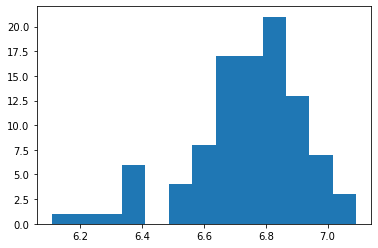

In [14]:
I = data[1:,1:2152].astype('float32')
plt.hist(np.log(np.sum(I,axis=1)),bins='auto');
XF = np.array([x for x in range(350,2501)]);

### Summarial Statistics: Means, variances, difference distributions

(0.0, 1.0)

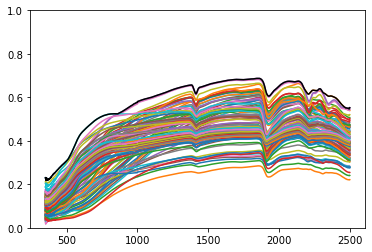

In [18]:
plt.plot(XF,I.T);
plt.plot(XF,np.max(I,axis=0),'black');
plt.ylim([0,1.0])

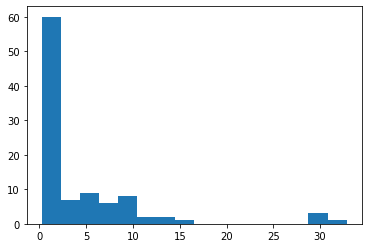

In [6]:
plt.hist(sample_soc,bins='auto');

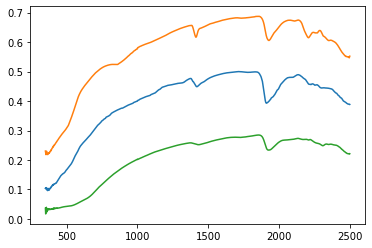

In [37]:
plt.plot(XF,np.median(I.T,axis=1))
plt.plot(XF,np.max(I.T,axis=1))
plt.plot(XF,np.min(I.T,axis=1))

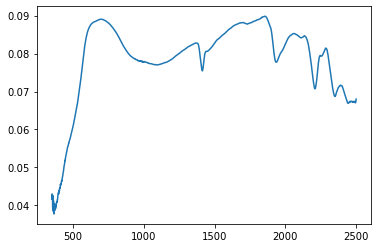

In [29]:
plt.plot(XF,np.sqrt(np.var(I.T,axis=1)))


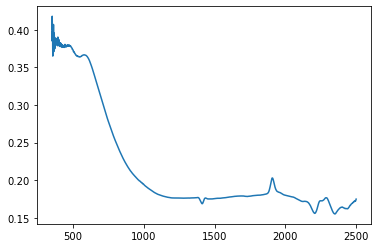

In [28]:
plt.plot(XF,np.sqrt(np.var(I.T,axis=1))/np.mean(I.T,axis=1))

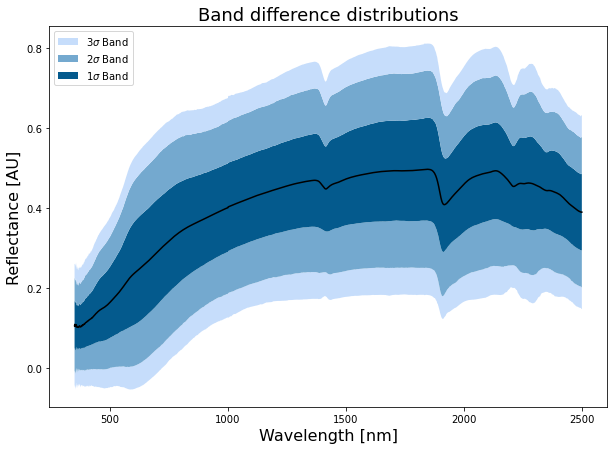

In [ ]:
def get_quantile_diff_dist_fast(tI) :
    return np.abs(I - I[:,np.newaxis]).reshape([I.shape[0] ** 2,I.shape[1]])

def get_quantile_diff_dist(tI, q) :
    NN = tI.shape[0]
    diffs = np.zeros([int(NN*(NN-1)/2),tI.shape[1]])
    
    ind=0
    for i in range(NN) :
        for j in range(i) :
            diffs[ind,:] = np.abs(tI[i,:] - tI[j,:])
            ind+=1
            
    print(diffs.shape)
    
    return np.quantile(diffs, q, axis=0)

diff_dist = get_quantile_diff_dist_fast(I);
vlamb68 = np.quantile(diff_dist, 0.68, axis=0) # 1 sigma
vlamb95 = np.quantile(diff_dist, 0.95, axis=0) # 2 sigma
vlamb99 = np.quantile(diff_dist, 0.99, axis=0) # 3 sigma

sandplot_y = [np.mean(I,axis=0) - vlamb99, vlamb99 - vlamb95, vlamb95 - vlamb68, 2.0*vlamb68, vlamb95 - vlamb68, vlamb99 - vlamb95]

COLORS = ["#FFFFFF", "#C6DDFB", "#74A9CF", "#045A8D", "#74A9CF", "#C6DDFB"]
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(XF, sandplot_y, colors=COLORS, baseline="zero", labels=[None,'3$\sigma$ Band','2$\sigma$ Band','1$\sigma$ Band']);
plt.plot(XF, np.mean(I, axis=0), 'black')

plt.ylabel('Reflectance',fontsize=16)
plt.xlabel('Wavelength [nm]',fontsize=16)

ax.set_title('Band difference distributions', fontsize=18)
plt.legend(loc='upper left')
plt.show()

### Correlations between soil variables and spectral lines

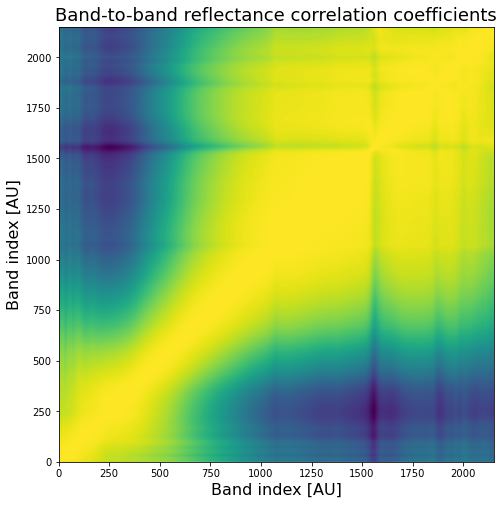

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.corrcoef(I, I, rowvar = False),interpolation='none')

plt.ylabel('Band index [AU]',fontsize=16)
plt.xlabel('Band index [AU]',fontsize=16)

ax.set_title('Band-to-band reflectance correlation coefficients', fontsize=18)

plt.xlim([0,2150])
plt.ylim([0,2150])

plt.show()

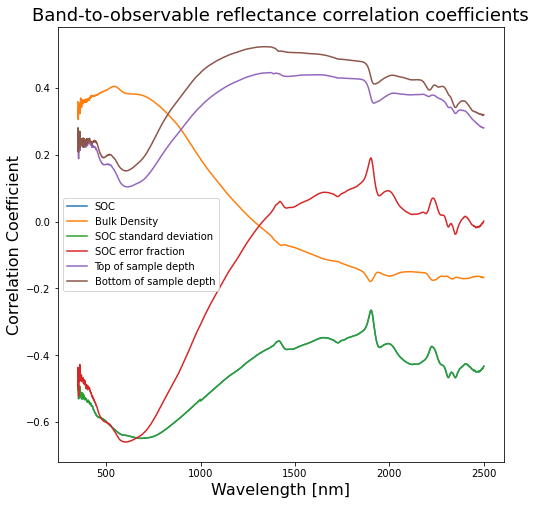

In [33]:
figbb, axbb = plt.subplots(figsize=(8, 8))
plt.plot(XF,np.corrcoef(I, sample_soc, rowvar = False)[:-1,-1],   label='SOC')
plt.plot(XF,np.corrcoef(I, sample_bd, rowvar = False)[:-1,-1],    label='Bulk Density')
plt.plot(XF,np.corrcoef(I, sample_socsd, rowvar = False)[:-1,-1], label='SOC standard deviation')
plt.plot(XF,np.corrcoef(I, sample_socsd/(sample_soc+0.0000001), rowvar = False)[:-1,-1], label='SOC error fraction')
plt.plot(XF,np.corrcoef(I, sample_top, rowvar = False)[:-1,-1],   label='Top of sample depth')
plt.plot(XF,np.corrcoef(I, sample_bot, rowvar = False)[:-1,-1],   label='Bottom of sample depth')


plt.ylabel('Correlation Coefficient',fontsize=16)
plt.xlabel('Wavelength [nm]',fontsize=16)

axbb.set_title('Band-to-observable reflectance correlation coefficients', fontsize=18)
axbb.legend()

plt.show()

### Correlations between soil variables independently of spectral lines

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.corrcoef(I, sample_soc, rowvar = False),interpolation='none')

plt.ylabel('Band index [AU]',fontsize=16)
plt.xlabel('Band index [AU]',fontsize=16)

ax.set_title('Band-to-band reflectance correlation coefficients', fontsize=18)

plt.xlim([0,2150])
plt.ylim([0,2150])

plt.show()

### Principal component analysis / k-means clustering breaking down classes of spectra

#### Correlations between soil variables for each spectral class

#### Correlations between soil variables for each spectral class

#### Identification of spectral troughs for each spectral class

# Full fit to pseudodata

In [18]:
KEndmembers = 87
NPoints = 99
MSpectra = 2151

In [ ]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedFsun, seedFk, seedNs):
        super().__init__()
        self.fs     = nn.Parameter(seedF)
        self.alphas = nn.Parameter(seedA)
        self.Ihat = 0;
        
        self.lsq = [];
        self.loss = [];
        self.bdsALoss = [];
        self.bdsFLoss = [];
        self.omrsLoss = [];
        self.diffloss1 = [];
        self.difflossfull = [];
        
    def forward(self, y):
        As,Is,Imax = y
        alphFull = torch.transpose(torch.cat((As.unsqueeze(1),torch.transpose(self.alphas,0,1)),dim=1),0,1)
        self.Ihat = torch.matmul(self.fs.T/torch.sum(self.fs,1),alphFull)
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.01 or > 0.99
        oobsA = torch.sum((-1.0 * (alphFull < 0.01).float() + (alphFull > 0.99).float()) * alphFull)

        # Add in a fake Lagrange multiplier to discourage Fs < 0
        oobsF = -1.0 * torch.sum((self.fs < 0.0).float() * self.fs)

        # Add in a fake Lagrange multiplier to discourage reflectances in F's that are above empirical max
        omrs = torch.sum(((self.fs.T/torch.sum(self.fs,1)).T > Imax.T.repeat(3,1)).float() * ((self.fs.T/torch.sum(self.fs,1)).T - Imax.T.repeat(3,1)))
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fs) ** 2)
        self.diffloss1 += [diffloss];
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fs)) ** 2)
        
        lsq = torch.sum((Is.T - self.Ihat) ** 2)
        loss = lsq * (1 + 10000.0*omrs + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF)
        
        self.lsq += [lsq]
        self.loss += [loss];
        self.bdsALoss += [oobsA];
        self.bdsFLoss += [oobsF];
        self.omrsLoss += [omrs];
        self.difflossfull += [diffloss];
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        return loss

### Pull F's and m_{SOC}'s, generate seed m's and alphas

In [15]:
# load JSON file with pure spectra
endMemMap = json.load(open('../data/endmember spectral data.json'))

# get reflectance spectra (y axis) and wavelength grid (x axis)
endMemList = endMemMap.keys();
#XF = endMemMap["General"]["Postprocessed Wavelength Axis"]
#F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]

# get density, radius info and merge into relevant arrays
rhos = [endMemMap[x]["Density (Mg/m^3)"] for x in endMemList]
rads = [endMemMap[x]["Effective Radius (nm)"] for x in endMemList]
rhorads = np.array(rhos)*np.array(rads)

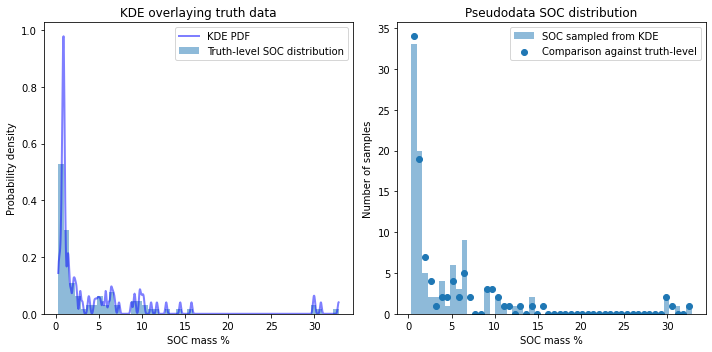

In [114]:
# pull m_SOC from a KDE of the RaCA histogram of SOC values
def kde(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

def generate_rand_from_pdf(pdf, x_grid):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(NPoints)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

hist, bins = np.histogram(sample_soc, bins=50)
x_grid = np.linspace(min(sample_soc), max(sample_soc), 1000)
kdepdf = kde(sample_soc, x_grid, bandwidth=0.1)
msoc = generate_rand_from_pdf(kdepdf, x_grid)

_, axarr = plt.subplots(1,2,figsize=(10,5))

axarr[0].hist(sample_soc, bins=50, density=True, alpha=0.5, label='Truth-level SOC distribution')
axarr[0].plot(x_grid, kdepdf, color='b', alpha=0.5, lw=2, label='KDE PDF')
axarr[0].set_xlabel("SOC mass %")
axarr[0].set_ylabel("Probability density")
axarr[0].set_title("KDE overlaying truth data")
axarr[0].legend()

axarr[1].scatter((bins[1:] + bins[:-1])/2,hist * NPoints/np.sum(hist), label='Comparison against truth-level')
axarr[1].hist(msoc, 50, alpha=0.5, label='SOC sampled from KDE')
axarr[1].legend()
axarr[1].set_xlabel("SOC mass %")
axarr[1].set_ylabel("Number of samples")
axarr[1].set_title("Pseudodata SOC distribution")
plt.tight_layout()
plt.show()

del hist, bins, x_grid, kdepdf, axarr

In [115]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return tA / np.sum(tA)

In [ ]:
# generate seed alphas from seed M's, specified below from initial literature

seedMsDict = {}

# feldspar 33.6%
# amphiboles & pyroxenes 5.6%
# micas 1.3%
# titanium minerals 0.5%
# apatite 0.2%
# clays 10.5%
# iron oxides 2.5%
# carbonates 5.6%
# other minerals 4.5%
# silica? 27.0%
# total: 91.3%, assume accurate for now

seedMsDict["silica"] = 0.27

# feldspars
seedMsDict["orthoclase"] = 0.336/3.
seedMsDict["albite"]     = 0.336/3.
seedMsDict["anorthite"]  = 0.336/3.

# amphiboles, pyroxenes
seedMsDict["hornblende"] = 0.0187
seedMsDict["tremolite"] = 0.0187
seedMsDict["cummingtonite"] = 0.0187

# micas
seedMsDict["biotite"] = 0.00325
seedMsDict["muscovite"] = 0.00325
seedMsDict["phlogopite"] = 0.00325
seedMsDict["vermiculite"] = 0.00325

# carbonates
seedMsDict["hydromagnesite"] = 0.008
seedMsDict["magnesite"] = 0.008
seedMsDict["dolomite"] = 0.008
seedMsDict["siderite"] = 0.008
seedMsDict["aragonite"] = 0.008
seedMsDict["magnesite"] = 0.008
seedMsDict["trona"] = 0.008

# small contributors
seedMsDict["apatite"]  = 0.002
seedMsDict["zircon"] = 0.005

# total pre-defined: 73.8%


### Generate SOC seed F

In [71]:
def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]

Fsoc = np.ones([MSpectra])
Fsoc = Fsoc - 0.5*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000).T,axis=0)

(0.0, 1.1)

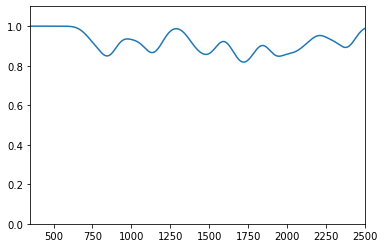

In [72]:
plt.plot(XF,Fsoc.T)
plt.xlim([350,2500])
plt.ylim([0,1.1])

### Generate reflectance pseudodata from mixing model

In [ ]:
# generate Is from Fs and As
I = np.dot(A.T,F)

# add random noise to I
noiseV = 0.0
noiseB = 0.0
I = I + noiseV*np.random.randn(NPoints, MSpectra) + noiseB

# Gaussian smearing?

In [ ]:
# seed data: A[1:,:] and initial F's
seedAs = torch.tensor((np.ones(A.shape)[1:,:]*(1.0-A[0,:])/(A.shape[0]-1)).tolist())
seedFs = torch.tensor()

# empirical data: (SOC values, reflectances, and max normalized reflectance)
ys = (A[0,:],I,maxI)

### Run fit

In [ ]:
model = LinearMixingModel(seedFs,seedAs)
optimizer = optim.Adam(model.parameters(), lr = 0.1)

for epoch in range(200000) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

    #print("Epoch ",epoch,": ", loss.detach().item())